In [10]:
from google.colab import drive
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount('/content/drive')

data=pd.read_csv('/content/drive/MyDrive/JOB/data2.csv', header=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Enriquecimento de dados

In [11]:
data['Income_per_Profession'] = data['Income'] / data.groupby('Profession')['Income'].transform('mean')

data['Above_Avg_Income'] = (data['Income'] > data.groupby('Profession')['Income'].transform('mean')).astype(int)

bins = [data['Income'].min(), data['Income'].quantile(0.33), data['Income'].quantile(0.66), data['Income'].max()]

labels = ['Baixo', 'Médio', 'Alto']

data['Income_Category'] = pd.cut(data['Income'], bins=bins, labels=labels, include_lowest=True)

data = pd.get_dummies(data, columns=['Income_Category'], drop_first=True)

for index, row in data.iterrows():
  data.loc[index, 'Age'] = random.randint(18,80)

data['Income_per_Age'] = data['Income'] / data['Age']

# ETAPA EDA

Média de renda por profissão

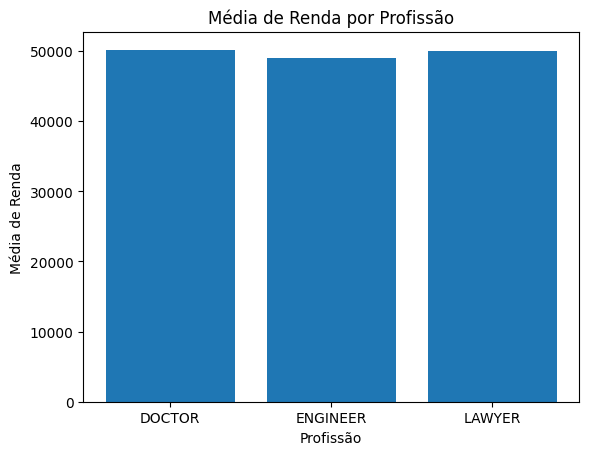

In [12]:
media_profissao = data.groupby(['Profession'])['Income'].mean()

plt.bar(media_profissao.index, media_profissao.values)
plt.xlabel('Profissão')
plt.ylabel('Média de Renda')
plt.title('Média de Renda por Profissão')
plt.show()

Média de idade por profissão

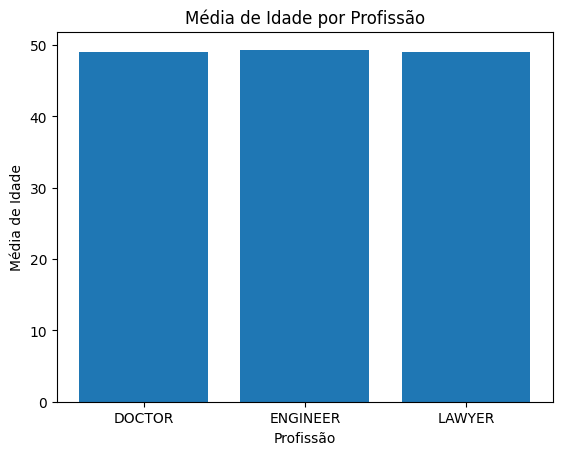

In [13]:
media_idade = data.groupby(['Profession'])['Age'].mean()

plt.bar(media_idade.index, media_idade.values)
plt.xlabel('Profissão')
plt.ylabel('Média de Idade')
plt.title('Média de Idade por Profissão')
plt.show()

Contagem de fraud por profissão

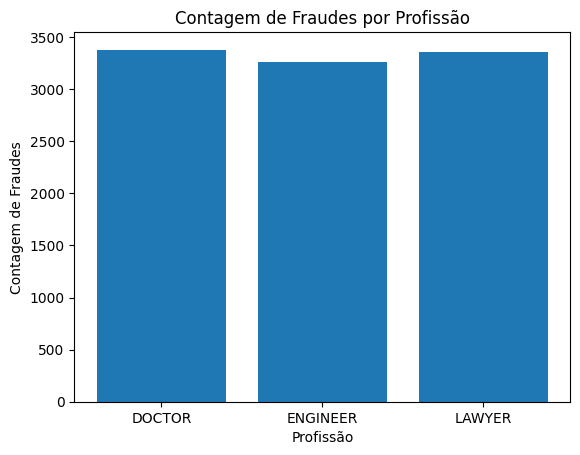

In [14]:
contagem_fraud = data.groupby(['Profession'])['Fraud'].count()

plt.bar(contagem_fraud.index, contagem_fraud.values)
plt.xlabel('Profissão')
plt.ylabel('Contagem de Fraudes')
plt.title('Contagem de Fraudes por Profissão')
plt.show()

# ETAPA DE MACHINE LEARNING

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

df_profession = ['Profession']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown = 'ignore'),
    df_profession),
    remainder='passthrough')

dados = one_hot_enc.fit_transform(data)

dados_transformados_df = pd.DataFrame(
    dados,
    columns=one_hot_enc.get_feature_names_out()
)

In [16]:
X = dados_transformados_df.drop(['remainder__Credit_card_number','remainder__Expiry','remainder__Security_code','remainder__Fraud'], axis=1)
y = dados_transformados_df['remainder__Fraud']

y = y.astype(int)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=42)


cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Modelo LogisticRegression

Regressão logística com validação cruzada aninhada (nested cross-validation) para buscar os melhores hiperparâmetros e avaliar o modelo.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Melhores hiperparâmetros: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       995
           1       0.48      0.46      0.47      1005

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



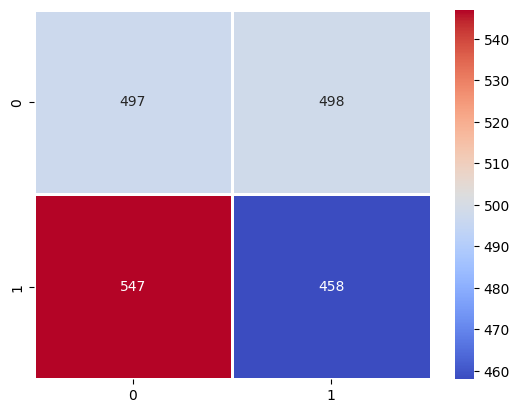

In [18]:
from sklearn.linear_model import LogisticRegression

max_iter= np.linspace(100,300,5, dtype=int)
c = [0.001,0.01,0.1,1,10]

param_grid_lr = [
     {'solver' : ['newton-cg', 'lbfgs'],
      'penalty' : ['l2'],
      'max_iter' : max_iter,
       'C' : c},
    {'solver' : ['liblinear'],
      'penalty' : ['l1', 'l2'],
      'max_iter' : max_iter,
      'C' : c},
]

lr_gs = GridSearchCV(LogisticRegression(), param_grid_lr, cv=cv_inner, scoring='accuracy', n_jobs=-1)

lr_nested_score = cross_val_score(lr_gs, x_train, y_train, cv=cv_outer, scoring='accuracy')

lr_gs.fit(x_train, y_train)

pred_lr_gs=lr_gs.predict(x_test)

best_params=lr_gs.best_params_

print("Melhores hiperparâmetros:", best_params)

cf_matrix = confusion_matrix(y_test, pred_lr_gs)

report = classification_report(y_test, pred_lr_gs)

print(report)

sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

# Modelo DecisionTreeClassifier

Arvóre de Decisão com validação cruzada aninhada (nested cross-validation) para buscar os melhores hiperparâmetros e avaliar o modelo.

Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 15, 'splitter': 'best'}
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       995
           1       0.48      0.46      0.47      1005

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000



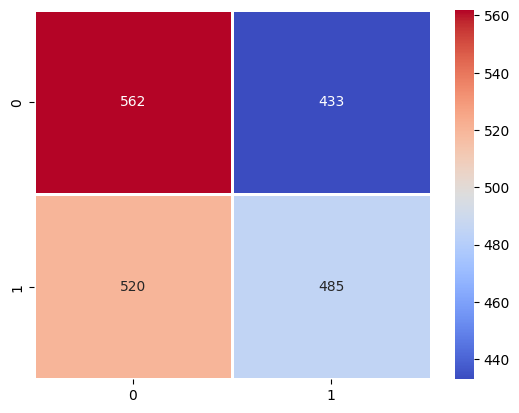

In [19]:
from sklearn.tree import DecisionTreeClassifier

param_grid_dt={
    'criterion':  ['gini', 'entropy'],
    'max_depth': np.linspace(6, 12, 4, dtype=int),
    'min_samples_split': np.linspace(5, 20, 4, dtype=int),
    'min_samples_leaf': np.linspace(5, 20, 4, dtype=int),
    'max_features': ['sqrt', 'log2'],
    'splitter': ['best', 'random']
}

dt_gs = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=cv_inner, scoring='accuracy', n_jobs=-1)

dt_nested_score = cross_val_score(dt_gs, x_train, y_train, cv=cv_outer)

dt_gs.fit(x_train, y_train)

best_params=dt_gs.best_params_

print("Melhores hiperparâmetros:", best_params)

pred_dt_gs=dt_gs.predict(x_test)

cf_matrix = confusion_matrix(y_test, pred_dt_gs)

report = classification_report(y_test, pred_lr_gs)

print(report)

sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

# Modelo RandomForestClassifier

Classificador de Floresta Aleatória com validação cruzada aninhada (nested cross-validation) para buscar os melhores hiperparâmetros e avaliar o modelo.

Melhores hiperparâmetros: {'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 6, 'n_estimators': 150}
              precision    recall  f1-score   support

           0       0.50      0.50      0.50       995
           1       0.50      0.50      0.50      1005

    accuracy                           0.50      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.50      0.50      0.50      2000



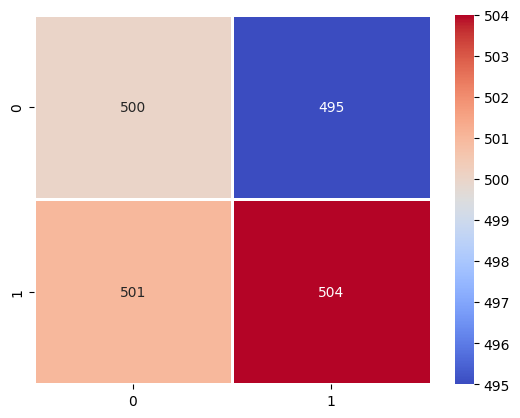

In [20]:
from sklearn.ensemble import RandomForestClassifier


param_grid_rfr = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

rfr_gs = GridSearchCV(RandomForestClassifier(), param_grid_rfr, cv=cv_inner, scoring='accuracy', n_jobs=-1)

rfr_nested_score = cross_val_score(rfr_gs, x_train, y_train, cv=cv_outer)

rfr_gs.fit(x_train, y_train)

best_params=rfr_gs.best_params_

print("Melhores hiperparâmetros:", best_params)


pred_rfr_gs=rfr_gs.predict(x_test)

cf_matrix = confusion_matrix(y_test, pred_rfr_gs)

report = classification_report(y_test, pred_rfr_gs)

print(report)

sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()